In [1]:
from MultioutputCNN_for_trEFM import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar as asb

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 1
plt.rc('font', size=14)

# Example usage of the trained multi-output convolutional neural network for trEFM 

The CNN intakes the relevant cantilever parameters k, Q, and resonance frequency (omega) in addition to the cantilever oscillation frequency response, omega(t). 

We obtain the cantilever oscillation frequency response via demodulating the deflection (raw oscillation) data collected during trEFM via the Hilbert transform. Code and examples for this part of the process can be found at: https://ffta.readthedocs.io/en/latest/.

The purpose of this notebook is to demonstrate how one would apply the trained multi-output CNN model to unlabeled and labeled experimental data.

In [2]:
param_ranges = [(1,10),(50,500),(0.01,0.99)] # parameter ranges for tau1, tau2, and A (coefficient)

In [3]:
m_parms = torch.load('best_model.pth') # load trained model 
m = SignalNet(parameter_ranges=param_ranges) # instantiate model
m.load_state_dict(state_dict=m_parms['model_state_dict']) # input trained weights/biases into model
m.eval() # set model in eval mode (no random dropout)

SignalNet(
  (fast_branch): Sequential(
    (0): Conv1d(15000, 32, kernel_size=(51,), stride=(2,), padding=(25,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ResidualBlock(
      (main_path): Sequential(
        (0): Conv1d(32, 64, kernel_size=(25,), stride=(2,), padding=(12,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_connection): Sequential(
        (0): Conv1d(32, 64, kernel_size=(1,), stride=(2,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (4): Dropout(p=0.2, inplace=False)
    (5): ResidualBlock(
  

In [4]:
time = np.linspace(0,2,20000)[3000:18000] 
# the experimental time is 0 to 2 ms with a sampling rate of 10 MHz.
# the data is cropped from 0.3 ms to 1.8  ms
# the laser/excitation event triggers at t=0.4 ms

## Analyzing labeled experimental data

In [5]:
vpulses = np.load('vpulses.npy') # 499 voltage pulses collected as described in manuscript
vpulses.shape # each voltage pulse is 15,000 indices long
# the first 3 indices in each voltage pulse are k, Q, and omega for the given cantilever

(499, 15003)

In [6]:
vpulse_labels = np.load('vpulse_labels.npy') # parameters used to apply bi-exponential voltage pulses as described in manuscript
vpulse_labels.shape # 499 pulses, 3 parameters each: [tau1 (us), tau2 (us), A (unitless)]

(499, 3)

In [7]:
print('k: {} N/m\nQ: {}\nomega: {} Hz'.format(vpulses[0][0], vpulses[0][1], vpulses[0][2]))

k: 18.227 N/m
Q: 366.037
omega: 243980.0 Hz


<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3089548378.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Normalized $\Delta$ Frequency')


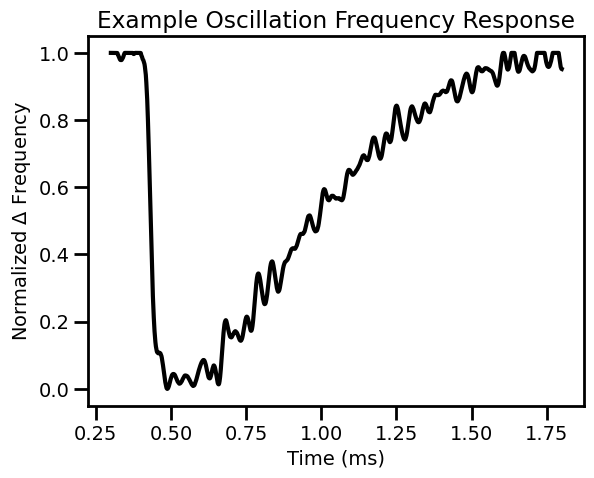

In [8]:
plt.figure()
plt.plot(time, vpulses[0][3:], lw=3, color='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized $\Delta$ Frequency')
plt.title('Example Oscillation Frequency Response')
plt.show()

In [9]:
vpulse_outputs = use_model(m, vpulses, param_ranges)
vpulse_outputs.shape

(499, 3)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3949022163.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel('True $\\tau_1$ ($\mu s$)')
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3949022163.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('CNN-extracted $\\tau_1$ ($\mu s$)')
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3949022163.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('True $\\tau_2$ ($\mu s$)')
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3949022163.py:11: SyntaxWarning: invalid escape sequence '\m'


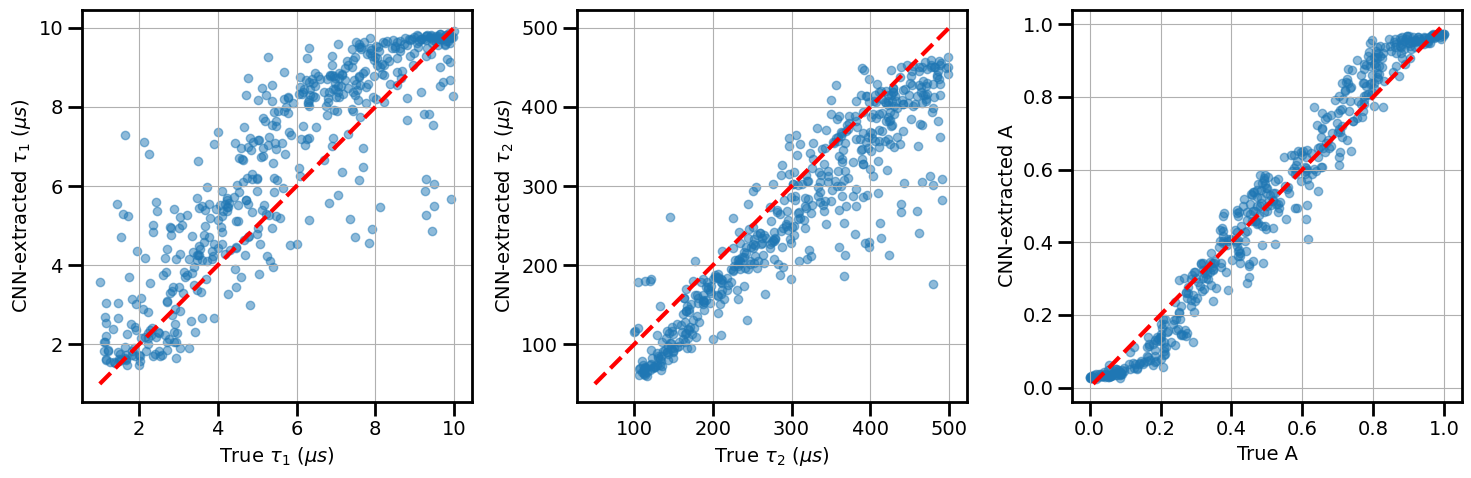

In [10]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].plot(param_ranges[0], param_ranges[0], ls='--', color='r', lw=3)
ax[0].scatter(vpulse_labels[:,0], vpulse_outputs[:,0], alpha=0.5)
ax[0].set_xlabel('True $\\tau_1$ ($\mu s$)')
ax[0].set_ylabel('CNN-extracted $\\tau_1$ ($\mu s$)')

ax[1].plot(param_ranges[1], param_ranges[1], ls='--', color='r', lw=3)
ax[1].scatter(vpulse_labels[:,1], vpulse_outputs[:,1], alpha=0.5)
ax[1].set_xlabel('True $\\tau_2$ ($\mu s$)')
ax[1].set_ylabel('CNN-extracted $\\tau_2$ ($\mu s$)')

ax[2].plot(param_ranges[2],param_ranges[2], ls='--', color='r', lw=3)
ax[2].scatter(vpulse_labels[:,2], vpulse_outputs[:,2], alpha=0.5)
ax[2].set_xlabel('True A')
ax[2].set_ylabel('CNN-extracted A')

for x in ax:
    x.grid()

plt.tight_layout()
plt.show()

In [13]:
ave_taus = [average_bi_tau(vpulse_outputs[i,0],vpulse_outputs[i,1],vpulse_outputs[i,2]) for i in range(vpulse_outputs.shape[0])]

In [15]:
true_ave_taus = [average_bi_tau(vpulse_lab[0],vpulse_lab[1],vpulse_lab[2]) for vpulse_lab in vpulse_labels]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3346946223.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('True <$\\tau$> ($\mu s$)')
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3346946223.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('CNN-extracted <$\\tau$> ($\mu s$)')


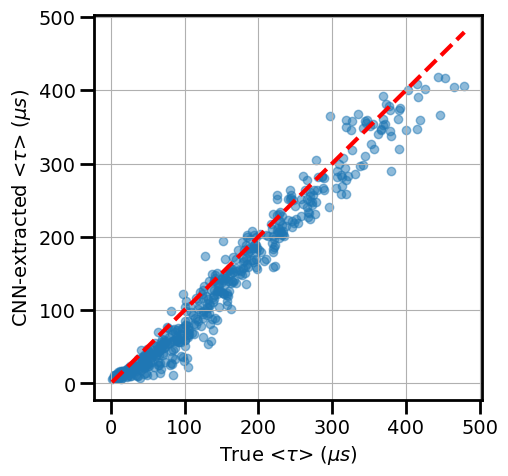

In [17]:
plt.figure(figsize=(5,5))
plt.plot([np.min(true_ave_taus),np.max(true_ave_taus)], [np.min(true_ave_taus),np.max(true_ave_taus)], ls='--', color='r', lw=3)
plt.scatter(true_ave_taus, ave_taus, alpha=0.5)
plt.xlabel('True <$\\tau$> ($\mu s$)')
plt.ylabel('CNN-extracted <$\\tau$> ($\mu s$)')
plt.grid()
plt.show()

## Analyizing unlabeled experimental data

In [18]:
# k, Q, and resfreq (omega) for image data -- obtained experimentally
k = 18.23
Q = 366
resfreq = 243980

In [19]:
topo = np.load('image_topography.npy') # image topography
topo.shape

(64, 128)

In [20]:
instfreq = np.load('image_instfreq.npy') # image instfreq
instfreq.shape # note that the whole 2 ms is saved; we need to crop according to the same crop we used for time

(64, 128, 20000)

In [21]:
instfreq_crop = instfreq[:,:,3000:18000]
instfreq_crop.shape

(64, 128, 15000)

In [22]:
image_input = np.empty((instfreq_crop.shape[0],instfreq_crop.shape[1],15003))
for i in range(image_input.shape[0]):
    for j in range(image_input.shape[1]):
        image_input[i,j,0] = k
        image_input[i,j,1] = Q
        image_input[i,j,2] = resfreq
        # normalize the raw instantaneous frequency between 0 and 1
        raw_instfreq = instfreq_crop[i,j]
        image_input[i,j,3:] = np.interp(raw_instfreq, (np.min(raw_instfreq),np.mean(raw_instfreq[:500])), (0,1))+1e-10

In [33]:
# column by column
# use_model takes a 2D array (nsamples, input_array)
image_output = np.empty((image_input.shape[0],image_input.shape[1],3))
for j in range(image_output.shape[1]):
    image_output[:,j,:] = use_model(m, image_input[:,j,:], param_ranges)

In [34]:
image_output.shape

(64, 128, 3)

In [35]:
image_ave_tau = np.empty((image_input.shape[0],image_input.shape[1]))
for i in range(image_ave_tau.shape[0]):
    for j in range(image_ave_tau.shape[1]):
        image_ave_tau[i,j] = average_bi_tau(image_output[i,j,0],image_output[i,j,1],image_output[i,j,2])

We can plot the average tau image:

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\3760355747.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(a,ax=ax,label='<$\\tau$> ($\mu s$)')


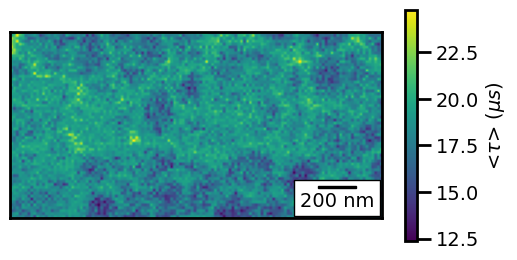

In [36]:
fig, ax = plt.subplots(figsize=(6,3))
a = ax.imshow(image_ave_tau, cmap='viridis')
asb0 = asb(ax.transData, 12.8, '200 nm', loc='lower right', frameon=True, size_vertical=1, pad=0.3)
ax.add_artist(asb0)
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(a,ax=ax,label='<$\\tau$> ($\mu s$)')
plt.show()

We can plot the individual time constants and coefficient maps as well, but these have no physical implications on the dynamics at play.

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\400595340.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(a,ax=ax[0],label='$\\tau_1$ ($\mu s$)')
C:\Users\mdbre\AppData\Local\Temp\ipykernel_27508\400595340.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(a,ax=ax[1],label='$\\tau_2$ ($\mu s$)')


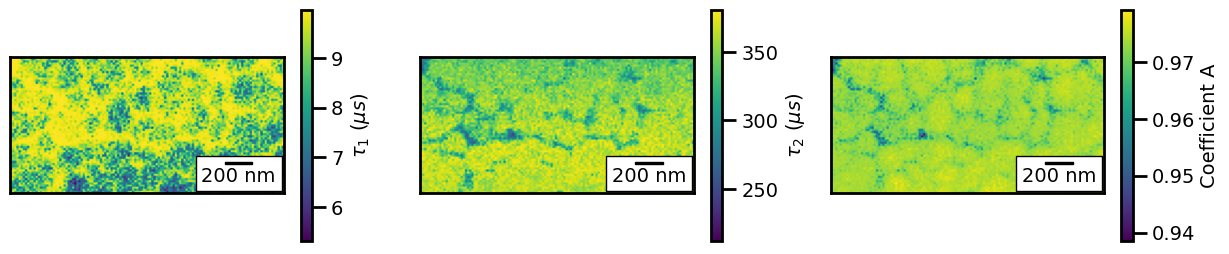

In [37]:
fig, ax = plt.subplots(ncols=3,figsize=(15,3))

a = ax[0].imshow(image_output[:,:,0], cmap='viridis')
asb0 = asb(ax[0].transData, 12.8, '200 nm', loc='lower right', frameon=True, size_vertical=1, pad=0.3)
ax[0].add_artist(asb0)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.colorbar(a,ax=ax[0],label='$\\tau_1$ ($\mu s$)')

a = ax[1].imshow(image_output[:,:,1], cmap='viridis')
asb0 = asb(ax[1].transData, 12.8, '200 nm', loc='lower right', frameon=True, size_vertical=1, pad=0.3)
ax[1].add_artist(asb0)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.colorbar(a,ax=ax[1],label='$\\tau_2$ ($\mu s$)')

a = ax[2].imshow(image_output[:,:,2], cmap='viridis')    
asb0 = asb(ax[2].transData, 12.8, '200 nm', loc='lower right', frameon=True, size_vertical=1, pad=0.3)
ax[2].add_artist(asb0)
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.colorbar(a,ax=ax[2],label='Coefficient A')